# An IA approach to algorithmic trading
<img src="https://github.com/danny2768/IAProject/blob/master/ProjectBanner.png?raw=true"  width="100%" >


## Introducción
En este proyecto, se aborda el problema de desarrollar un sistema de trading automatizado utilizando técnicas de aprendizaje automático basadas en regresión. El objetivo es crear un modelo que sea capaz de predecir el precio de los activos financieros y tomar decisiones de inversión en tiempo real.

## Metodología
Para construir el sistema de trading, se utilizarán técnicas de regresión supervisada, específicamente modelos de regresión de árbol de decisión y regresion basado en maquinas de vectores de soporte. El modelo se entrenará con datos históricos de los distintos activos financieros y se probará en datos de prueba para evaluar su precisión y eficacia.

Se utilizará la plataforma de Google Colab para el desarrollo del proyecto, lo que permitirá la colaboración en tiempo real y el acceso a bibliotecas de aprendizaje automático de Python, como Scikit-learn.

## Datos
Se utilizarán datos históricos de precios de divisas, en este caso especifico utilizaremos el par EUR/USD. Los datos se obtendrán de TrueFx - https://www.truefx.com/truefx-historical-downloads/.

Se espera obtener una predicción precisa del precio de los activos financieros, lo que permitirá tomar decisiones de inversión informadas y maximizar el rendimiento de la inversión.


In [67]:
#@title **MONTAR EL DRIVE** { display-mode: "form" }
import os
from google.colab import drive

path_project = "Colab Notebooks/IA/Proyecto" #@param {type:"string"}
path = "/content/drive/My Drive/" + path_project
drive.mount('/content/drive')
os.chdir(path)
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/IA/Proyecto


In [68]:
#@title **Load libs** { display-mode: "form" }
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


In [69]:
#@title **Unzip csv** { display-mode: "form" }

# !unzip EURUSD-2022-01.zip
# !unzip EURUSD-2022-02.zip
# !unzip EURUSD-2022-03.zip
# !unzip EURUSD-2022-04.zip
# !unzip EURUSD-2022-05.zip

# !unzip EURUSD-2022-06.zip
# !unzip EURUSD-2022-07.zip
# !unzip EURUSD-2022-08.zip
# !unzip EURUSD-2022-09.zip
# !unzip EURUSD-2022-10.zip
# !unzip EURUSD-2022-11.zip
# !unzip EURUSD-2022-12.zip

!ls

'An IA approach to algorithmic trading.ipynb'   ExposicionRecursos
 datos_tick_2022-1.csv			        ProjectBanner.png
 datos_tick_2022-2.csv			        RawData
 datos_tick_2022-3.csv			        Untitled0.ipynb
 datos_tick_2022.csv			        ZipCsv


In [ ]:
#@title **Analicemos el Dataset incial**

rawDf = pd.read_csv('RawData/EURUSD-2022-10.csv')
print('Cantidad de filas y columnas de la divisa EUR/USD - Temporalidad tick:', rawDf.shape)

print('Esto es muchisima informacion, estamos hablando de que tendriamos en total, de Enero a Diciembre:', rawDf.shape[0] * 12)

rawDf.head(5)

Cantidad de filas y columnas de la divisa EUR/USD - Temporalidad tick: (23718525, 4)
Esto es muchisima informacion, estamos hablando de que tendriamos en total, de Enero a Diciembre: 284622300


,EUR/USD,20221002 22:00:00.026,0.97951,0.98004
0,EUR/USD,20221002 22:00:00.031,0.97944,0.97991
1,EUR/USD,20221002 22:00:00.083,0.97934,0.98000
2,EUR/USD,20221002 22:00:00.144,0.97944,0.97991
3,EUR/USD,20221002 22:00:00.146,0.97935,0.98001
4,EUR/USD,20221002 22:00:00.200,0.97936,0.98002


In [ ]:
#@title **Manipulando el dataset (1)**

# Meses ENERO - MAYO del 2022

# Creamos un DataFrame vacio con las siguientes columnas
df = pd.DataFrame(columns=["Pair", "Timestamp", "Bid", "Ask"])

# Creamos una lista para agregar el DataFrame de cada mes
df_list = []

# Recorremos los archivos y los agregamos a la lista creada.
for i in range(1, 6):
    filename = "EURUSD-2022-0" + str(i) + ".csv"
    df_month = pd.read_csv(filename, header=None)
    df_month.columns = ["Pair", "Timestamp", "Bid", "Ask"]
    df_list.append(df_month)

# Concatenación de todos los dataframes de cada mes en un solo dataframe. 
# Usamos ignore_index=True para reiniciar los indices del dataframe resultante.
df = pd.concat(df_list, ignore_index=True)

# Convertimos la columna 'Timestamp' a datetime.
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y%m%d %H:%M:%S.%f")

# Definimos como indice dicha columna.
df = df.set_index("Timestamp")

# Para fines e procesamiento nos aseguramos que las columnas bid y ask sean de tipo numerico, para este caso float.
df['Bid'] = df['Bid'].astype(float)
df['Ask'] = df['Ask'].astype(float)

# Creamos una lista de nombres de columna de tipo numerico. Estas columnas se utilizaran para crear las columnas open, high, low, close
# para cada intervalo de 5 minutos.
numeric_cols = ['Bid_Open', 'Bid_High', 'Bid_Low', 'Bid_Close', 'Ask_Open', 'Ask_High', 'Ask_Low', 'Ask_Close']

# Este ciclo for recorre cada columna y crea las columnas correspondientes de OHLC
# utilizando la función resample() y la función ohlc() para cada columna "Bid" y "Ask".
for col in numeric_cols:
    if col.startswith("Bid_"):
        new_col_name = col.replace("Bid_", "")
        df[new_col_name+"_Open"] = df['Bid'].resample('5T').ohlc()['open']
        df[new_col_name+"_High"] = df['Bid'].resample('5T').ohlc()['high']
        df[new_col_name+"_Low"] = df['Bid'].resample('5T').ohlc()['low']
        df[new_col_name+"_Close"] = df['Bid'].resample('5T').ohlc()['close']
    elif col.startswith("Ask_"):
        new_col_name = col.replace("Ask_", "")
        df[new_col_name+"_Open"] = df['Ask'].resample('5T').ohlc()['open']
        df[new_col_name+"_High"] = df['Ask'].resample('5T').ohlc()['high']
        df[new_col_name+"_Low"] = df['Ask'].resample('5T').ohlc()['low']
        df[new_col_name+"_Close"] = df['Ask'].resample('5T').ohlc()['close']

df = df.dropna()
df.to_csv('datos_tick_2022-1.csv')

In [ ]:
#@title **Manipulando el dataset (2)**

# Meses JUNIO - SEPTIEMBRE del 2022**

df = pd.DataFrame(columns=["Pair", "Timestamp", "Bid", "Ask"])
df_list = []

for i in range(6, 10):
    filename = "EURUSD-2022-" + str(i).zfill(2) + ".csv"
    df_month = pd.read_csv(filename, header=None)
    df_month.columns = ["Pair", "Timestamp", "Bid", "Ask"]
    df_list.append(df_month)

df = pd.concat(df_list, ignore_index=True)
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y%m%d %H:%M:%S.%f")
df = df.set_index("Timestamp")

df['Bid'] = df['Bid'].astype(float)
df['Ask'] = df['Ask'].astype(float)

numeric_cols = ['Bid_Open', 'Bid_High', 'Bid_Low', 'Bid_Close', 'Ask_Open', 'Ask_High', 'Ask_Low', 'Ask_Close']
for col in numeric_cols:
    if col.startswith("Bid_"):
        new_col_name = col.replace("Bid_", "")
        df[new_col_name+"_Open"] = df['Bid'].resample('5T').ohlc()['open']
        df[new_col_name+"_High"] = df['Bid'].resample('5T').ohlc()['high']
        df[new_col_name+"_Low"] = df['Bid'].resample('5T').ohlc()['low']
        df[new_col_name+"_Close"] = df['Bid'].resample('5T').ohlc()['close']
    elif col.startswith("Ask_"):
        new_col_name = col.replace("Ask_", "")
        df[new_col_name+"_Open"] = df['Ask'].resample('5T').ohlc()['open']
        df[new_col_name+"_High"] = df['Ask'].resample('5T').ohlc()['high']
        df[new_col_name+"_Low"] = df['Ask'].resample('5T').ohlc()['low']
        df[new_col_name+"_Close"] = df['Ask'].resample('5T').ohlc()['close']

df = df.dropna()
df.to_csv('datos_tick_2022-2.csv')

In [ ]:
#@title **Manipulando el dataset(3)**

# Meses OCTUBRE - DICIEMBRE del 2022

df = None
df = pd.DataFrame(columns=["Pair", "Timestamp", "Bid", "Ask"])
df_list = []

for i in range(10, 13):
    filename = "EURUSD-2022-" + str(i).zfill(2) + ".csv"
    df_month = pd.read_csv(filename, header=None)
    df_month.columns = ["Pair", "Timestamp", "Bid", "Ask"]
    df_list.append(df_month)

df = pd.concat(df_list, ignore_index=True)
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y%m%d %H:%M:%S.%f")
df = df.set_index("Timestamp")

df['Bid'] = df['Bid'].astype(float)
df['Ask'] = df['Ask'].astype(float)

numeric_cols = ['Bid_Open', 'Bid_High', 'Bid_Low', 'Bid_Close', 'Ask_Open', 'Ask_High', 'Ask_Low', 'Ask_Close']
for col in numeric_cols:
    if col.startswith("Bid_"):
        new_col_name = col.replace("Bid_", "")
        df[new_col_name+"_Open"] = df['Bid'].resample('5T').ohlc()['open']
        df[new_col_name+"_High"] = df['Bid'].resample('5T').ohlc()['high']
        df[new_col_name+"_Low"] = df['Bid'].resample('5T').ohlc()['low']
        df[new_col_name+"_Close"] = df['Bid'].resample('5T').ohlc()['close']
    elif col.startswith("Ask_"):
        new_col_name = col.replace("Ask_", "")
        df[new_col_name+"_Open"] = df['Ask'].resample('5T').ohlc()['open']
        df[new_col_name+"_High"] = df['Ask'].resample('5T').ohlc()['high']
        df[new_col_name+"_Low"] = df['Ask'].resample('5T').ohlc()['low']
        df[new_col_name+"_Close"] = df['Ask'].resample('5T').ohlc()['close']

df = df.dropna()
df.to_csv('datos_tick_2022-3.csv')

In [ ]:
#@title **Unimos los archivos resultantes**
import pandas as pd

df1 = pd.read_csv("datos_tick_2022-1.csv")
df2 = pd.read_csv("datos_tick_2022-2.csv")
df3 = pd.read_csv("datos_tick_2022-3.csv")

df = pd.concat([df1, df2, df3], ignore_index=True)

df.to_csv("datos_tick_2022.csv", index=False)


In [ ]:
df.shape

(510, 20)

In [ ]:
df.head()

,Timestamp,Pair,Bid,Ask,Open_Open,Open_High,Open_Low,Open_Close,High_Open,High_High,High_Low,High_Close,Low_Open,Low_High,Low_Low,Low_Close,Close_Open,Close_High,Close_Low,Close_Close
0,2022-01-05 09:40:00,EUR/USD,1.13033,1.13040,1.13040,1.13046,1.13002,1.13009,1.13040,1.13046,1.13002,1.13009,1.13040,1.13046,1.13002,1.13009,1.13040,1.13046,1.13002,1.13009
1,2022-01-05 15:15:00,EUR/USD,1.13430,1.13436,1.13436,1.13443,1.13415,1.13443,1.13436,1.13443,1.13415,1.13443,1.13436,1.13443,1.13415,1.13443,1.13436,1.13443,1.13415,1.13443
2,2022-01-07 13:40:00,EUR/USD,1.12974,1.12983,1.12983,1.13042,1.12932,1.12991,1.12983,1.13042,1.12932,1.12991,1.12983,1.13042,1.12932,1.12991,1.12983,1.13042,1.12932,1.12991
3,2022-01-11 18:50:00,EUR/USD,1.13675,1.13680,1.13680,1.13688,1.13663,1.13664,1.13680,1.13688,1.13663,1.13664,1.13680,1.13688,1.13663,1.13664,1.13680,1.13688,1.13663,1.13664
4,2022-01-14 12:15:00,EUR/USD,1.14535,1.14538,1.14538,1.14538,1.14470,1.14487,1.14538,1.14538,1.14470,1.14487,1.14538,1.14538,1.14470,1.14487,1.14538,1.14538,1.14470,1.14487


## Columna y sus significados
`1. Timestamp: la marca de tiempo (fecha y hora) de cada registro.`

`2. Pair: el par de divisas para el cual se está haciendo el análisis.`

3. Bid: el precio máximo al que un comprador está dispuesto a comprar un activo.

4. Ask: el precio mínimo al que un vendedor está dispuesto a vender un activo.

`5. Open_Open: el precio de apertura en el primer registro de cada período de tiempo.`

6. Open_High: el precio más alto durante el período de tiempo, desde el precio de apertura hasta el precio más alto alcanzado.

7. Open_Low: el precio más bajo durante el período de tiempo, desde el precio de apertura hasta el precio más bajo alcanzado.

8. Open_Close: el precio de cierre en el último registro de cada período de tiempo.

9. High_Open: la diferencia entre el precio máximo alcanzado durante el período de tiempo y el precio de apertura.

`10.*High_High: la diferencia entre el precio máximo alcanzado durante el período de tiempo y el precio más alto alcanzado.`

11. High_Low: la diferencia entre el precio máximo alcanzado durante el período de tiempo y el precio más bajo alcanzado.

12. High_Close: la diferencia entre el precio máximo alcanzado durante el período de tiempo y el precio de cierre.

13. Low_Open: la diferencia entre el precio mínimo alcanzado durante el período de tiempo y el precio de apertura.

`14. Low_High: la diferencia entre el precio mínimo alcanzado durante el período de tiempo y el precio más alto alcanzado.`

`15. Low_Low: la diferencia entre el precio mínimo alcanzado durante el período de tiempo y el precio más bajo alcanzado.`

16. Low_Close: la diferencia entre el precio mínimo alcanzado durante el período de tiempo y el precio de cierre.

17. Close_Open: la diferencia entre el precio de cierre y el precio de apertura.

18. Close_High: la diferencia entre el precio de cierre y el precio más alto alcanzado durante el período de tiempo.

19. Close_Low: la diferencia entre el precio de cierre y el precio más bajo alcanzado durante el período de tiempo.

`20. Close_Close: la diferencia entre el precio de cierre en el último registro y el precio de cierre en el registro anterior.`

# Codigo

## Importamos las librerias a utilizar

In [70]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from math import sqrt


## Cargamos el dataset


In [71]:
df = pd.read_csv('datos_tick_2022.csv')

## Analisis de mercado

- Calculo de puntos de pivote
- Calculo zonas de soporte y resistencia
- Filtro de zonas confirmadas y se creacion de DataFrame

### Puntos de pivote

Los puntos pivote constituyen un indicador técnico que los operadores aprovechan para predecir las próximas zonas de importancia técnica, como el soporte y la resistencia. **Se calculan promediando los precios máximos, mínimos y de cierre de un periodo anterior** . Puede ser un día, una semana o un mes.

Los day traders suelen utilizarlo como método para detectar tendencias a corto plazo. Por ejemplo, si el par EUR/USD está cotizando por encima de P del día anterior, pueden pensar que continuará subiendo, y buscarán comprar el par.

---


### Zonas de soporte y resistencia

Son niveles de precios en los que el mercado ha experimentado una resistencia o soporte significativo en el pasado. Las zonas de soporte son niveles de precios en los que el mercado ha tenido una tendencia a subir, mientras que las zonas de resistencia son niveles de precios en los que el mercado ha tendido a caer. Estas zonas son importantes porque a menudo indican que el precio puede rebotar o retroceder en el futuro.

---

### Implementacion:

In [72]:
# Calcular zonas de soporte y resistencia
def confirm_zone(df, zone_name, confirmation):
    # Calcular el promedio de los precios de la zona
    zone_mean = df[zone_name].mean()
    confirmed = [False] * len(df)
    confirmations = 0
    for i in range(len(df)):
        # Verificar si el precio cruzó la zona de soporte/resistencia
        if (df["Low_Low"][i] < zone_mean and df["High_High"][i] > zone_mean):
            confirmations += 1
            if confirmations >= confirmation:
                confirmed[i] = True
                confirmations = 0
        else:
            confirmations = 0
    return confirmed

df["Pivot Point"] = (df["High_High"] + df["Low_Low"] + df["Close_Close"]) / 3
df["Pivot Resistance 1"] = 2 * df["Pivot Point"] - df["Low_Low"]
df["Pivot Support 1"] = 2 * df["Pivot Point"] - df["High_High"]
df["Pivot Resistance 2"] = df["Pivot Point"] + df["Pivot Resistance 1"] - df["Pivot Support 1"]
df["Pivot Support 2"] = df["Pivot Point"] - df["Pivot Resistance 1"] + df["Pivot Support 1"]
df["Pivot Resistance 3"] = df["High_High"] + 2 * (df["Pivot Point"] - df["Low_Low"])
df["Pivot Support 3"] = df["Low_Low"] - 2 * (df["High_High"] - df["Pivot Point"])


# Calcular confirmaciones de zonas de soporte y resistencia
df["Pivot Point Confirmed"] = confirm_zone(df, "Pivot Point", 2)
df["Pivot Resistance 1 Confirmed"] = confirm_zone(df, "Pivot Resistance 1", 2)
df["Pivot Support 1 Confirmed"] = confirm_zone(df, "Pivot Support 1", 2)
df["Pivot Resistance 2 Confirmed"] = confirm_zone(df, "Pivot Resistance 2", 2)
df["Pivot Support 2 Confirmed"] = confirm_zone(df, "Pivot Support 2", 2)
df["Pivot Resistance 3 Confirmed"] = confirm_zone(df, "Pivot Resistance 3", 2)
df["Pivot Support 3 Confirmed"] = confirm_zone(df, "Pivot Support 3", 2)

# Filtrar zonas de soporte y resistencia confirmadas
confirmed_zones = ["Pivot Point Confirmed", "Pivot Resistance 1 Confirmed", "Pivot Support 1 Confirmed",
                   "Pivot Resistance 2 Confirmed", "Pivot Support 2 Confirmed", "Pivot Resistance 3 Confirmed", "Pivot Support 3 Confirmed"]

# Crar dataFrame con las zonas confirmadas
df_zones = df[confirmed_zones]

# Crear dataframe con precios de cierre y apertura
df_price = df[["Open_Open", "Close_Close"]]

# Crear dataframe de datos de entrada para el modelo
X = pd.concat([df_zones, df_price], axis=1)

# Crear dataframe de datos de salida para el modelo
y = df["Close_Close"].shift(-1)

# Eliminar la última fila de los datos de entrada y salida
X = X[:-1]
y = y[:-1]

## Dividimos los datos en entrenamiento y testeo

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=21)

## Definimos los parametros para cada modelo

In [74]:
decision_tree_params = {
    'max_depth': [5, 9, 10, 11, 15],
}

random_forest_params = {
    'n_estimators': [5, 10, 14, 15, 16, 20],
    'max_depth': [3, 5, 6, 7, 8, 9],
}

svm_params = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
}

## Entrenamos los modelos

In [75]:
# Entrenar modelo Decision Tree
dt_reg = DecisionTreeRegressor(random_state=21)
dt_reg_grid = GridSearchCV(dt_reg, decision_tree_params, cv=5, scoring='neg_mean_squared_error')
dt_reg_grid.fit(X_train, y_train)
best_dt = dt_reg_grid.best_estimator_
dt_rmse = sqrt(-dt_reg_grid.best_score_)
print(f"Decision Tree Regressor RMSE: {dt_rmse} (best parameter: {best_dt.get_params()['max_depth']})")

# Entrenar modelo Random Forest
rf_reg = RandomForestRegressor(random_state=21)
rf_reg_grid = GridSearchCV(rf_reg, random_forest_params, cv=5, scoring='neg_mean_squared_error')
rf_reg_grid.fit(X_train, y_train)
best_rf = rf_reg_grid.best_estimator_
rf_rmse = sqrt(-rf_reg_grid.best_score_)
print(f"Random Forest Regressor RMSE: {rf_rmse} (best parameters: {best_rf.get_params()['n_estimators']}, {best_rf.get_params()['max_depth']})")

# Entrenar modelo SVM
svm_reg = SVR()
svm_reg_grid = GridSearchCV(svm_reg, svm_params, cv=5, scoring='neg_mean_squared_error')
svm_reg_grid.fit(X_train, y_train)
best_svm = svm_reg_grid.best_estimator_
svm_rmse = sqrt(-svm_reg_grid.best_score_)
print(f"SVM Regressor RMSE: {svm_rmse} (best parameters: {best_svm.get_params()['kernel']}, {best_svm.get_params()['C']})")

Decision Tree Regressor RMSE: 0.013475996586318243 (best parameter: 10)
Random Forest Regressor RMSE: 0.013706411280566174 (best parameters: 15, 7)
SVM Regressor RMSE: 0.06295352045984533 (best parameters: linear, 0.1)


## Obtenemos predicciones y creamos un DataFrame con tados reales y predicciones

In [76]:
# Obtener predicciones
y_pred_dt = best_dt.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_pred_svm = best_svm.predict(X_test)

# Crear DataFrame
df_results = pd.DataFrame({'Real': y_test, 'DecisionTree': y_pred_dt, 'RandomForest': y_pred_rf, 'SVM': y_pred_svm}, index=X_test.index)

In [77]:
df_results.head()

,Real,DecisionTree,RandomForest,SVM
407,0.99208,0.992963,0.993271,1.05107
408,0.99208,0.992963,0.992283,1.05107
409,0.98851,0.992963,0.992283,1.05107
410,0.99289,0.986410,0.990820,1.05107
411,0.99345,0.992963,0.992572,1.05107


# Analisis de resultados

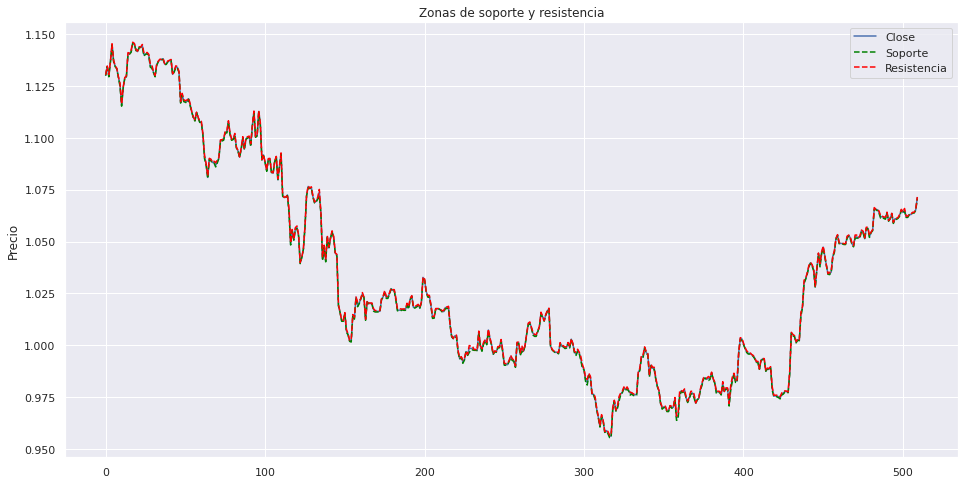

In [112]:
import matplotlib.pyplot as plt
# Gráfica de zonas de soporte y resistencia
fig1, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(df['Close_Close'])
ax1.plot(df['Pivot Support 1'], linestyle='--', color='green')
ax1.plot(df['Pivot Resistance 1'], linestyle='--', color='red')
ax1.set_title('Zonas de soporte y resistencia')
ax1.set_ylabel('Precio')
ax1.legend(['Close', 'Soporte', 'Resistencia'])

# ax1.set_xlim([0, 100])
# ax1.set_ylim([1.075, 1.150])

# ax1.set_xlim([15, 25])
# ax1.set_ylim([1.140, 1.146])

plt.show()


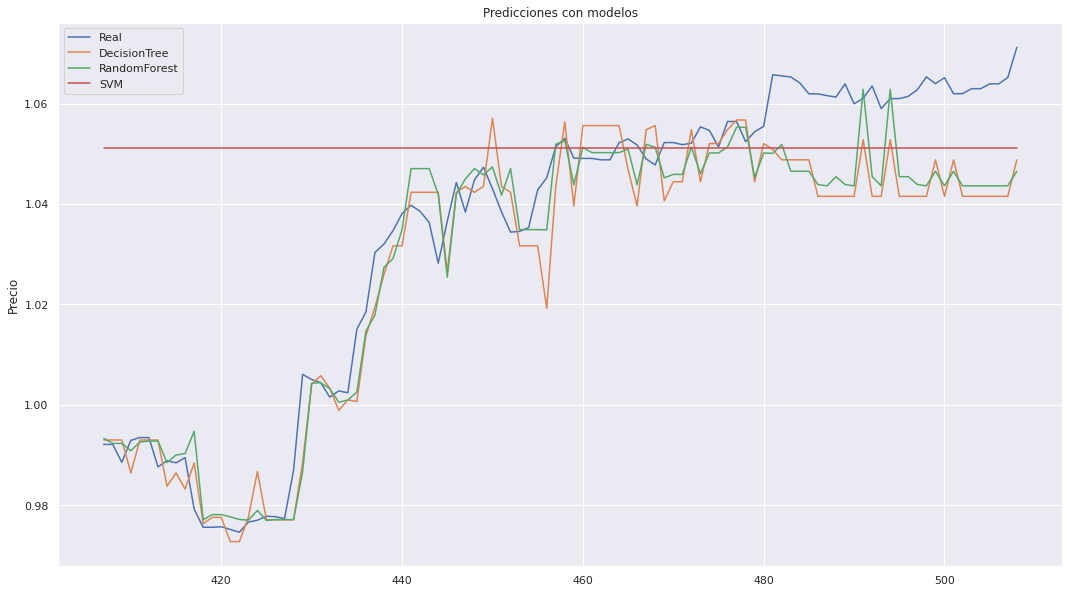

In [103]:
# Gráfica de predicciones
fig2, ax2 = plt.subplots(figsize=(18, 10))
df_results.plot(ax=ax2)
ax2.set_title('Predicciones con modelos')
# ax2.set_xlabel('Tiempo')
ax2.set_ylabel('Precio')
plt.show()

- Decision Tree Regressor RMSE: 0.013475996586318243 (best parameter: 10)
- Random Forest Regressor RMSE: 0.013706411280566174 (best parameters: 15, 7)
- SVM Regressor RMSE: 0.06295352045984533 (best parameters: linear, 0.1)

# Conclusiones

1. Las zonas de soporte y resistencia son herramientas útiles para identificar posibles puntos de entrada o salida en el mercado. En la gráfica se puede observar que en varias ocasiones el precio se ha mantenido en el rango de la zona de soporte o resistencia, lo que sugiere que estos niveles son importantes para el mercado.

2. A pesar de que el Decision Tree Regressor tuvo el mejor rendimiento en términos de RMSE, es importante notar que en algunos puntos del precio el modelo tuvo dificultades para predecir con precisión. Esto sugiere que el modelo puede ser sensible a ciertos movimientos bruscos en el mercado y puede tener dificultades para adaptarse a cambios abruptos en las condiciones del mercado.

3. El Random Forest Regressor también tuvo un buen rendimiento en términos de RMSE y se mantuvo cerca del precio real. Además, en la gráfica comparativa se puede observar que el modelo tuvo una mejor capacidad para adaptarse a los cambios en el precio en comparación con el Decision Tree Regressor.

4. Es importante considerar que los modelos de predicción se basan en datos históricos y, por lo tanto, pueden no ser capaces de predecir con precisión eventos inesperados o movimientos bruscos en el mercado.

5. En general, los modelos de predicción pueden ser una herramienta valiosa para los inversores y traders en el mercado financiero, ya que pueden ayudar a identificar oportunidades de entrada y salida y a mejorar la toma de decisiones. Sin embargo, es importante recordar que los modelos no son infalibles y deben utilizarse como una herramienta complementaria a la experiencia y el conocimiento del trader.
